# Введение в RL и пакет Gymnasium

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://gymnasium.farama.org/
* https://pypi.org/project/ufal.pybox2d/
* https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/
* https://gymnasium.farama.org/api/spaces/fundamental/
* https://gymnasium.farama.org/environments/toy_text/blackjack/

## Задачи для совместного разбора

1\. Рассмотрите пример создания окружения `gymnasium` и основные этапы взаимодействия с этим окружением.

<img src="https://gymnasium.farama.org/_images/AE_loop.png" width="300"/>

In [13]:
# !pip install gymnasium

In [14]:
# !pip install swig

In [15]:
# !pip install "gymnasium[box2d]"

In [16]:
import gymnasium as gym

In [71]:
env = gym.make("LunarLander-v3", render_mode="human")

def make_action(obs, env):
  # тут вы должны исопльзовать состояние
  return env.action_space.sample()

# ---
obs, _ = env.reset()
is_done = False
rewards = []
while not is_done:
  action = make_action(obs, env)
  obs, reward, terminated, truncated, info = env.step(action)

  is_done = terminated or truncated
  rewards.append(reward)
# --

env.close()

In [72]:
sum(rewards)

-107.65420441902552

## Задачи для самостоятельного решения

In [54]:
import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import RecordVideo
import os
import numpy as np
import random

<p class="task" id="1"></p>

1\. Создайте окружение `Blackjack-v1`. Сыграйте `N=10000` игр, выбирая действие случайным образом. Посчитайте и выведите на экран долю выигранных игр.

- [ ] Проверено на семинаре

In [20]:
env = gym.make("Blackjack-v1")

def make_action(obs, env):
    return env.action_space.sample()

N = 10000
wins = 0

def is_win(reward):
    return reward > 0

for _ in range(N):
    obs = env.reset()
    is_done = False
    while not is_done:
        action = make_action(obs, env)
        obs, reward, terminated, truncated, info = env.step(action)

        is_done = terminated or truncated

    if is_win(reward):
        wins += 1

env.close()

win_ratio = wins / N
win_ratio

0.2849

<p class="task" id="2"></p>

2\. Создайте окружение `Blackjack-v1`. Предложите стратегию, которая позволит, в среднем, выигрывать чаще, чем случайный выбор действия. Реализуйте эту стратегию и сыграйте `N=10000` игр, выбирая действие согласно этой стратегии. Посчитайте и выведите на экран долю выигранных игр.

- [ ] Проверено на семинаре

In [21]:
env = gym.make("Blackjack-v1")

def make_action(obs, env):
    return 0 if obs[0] >= 12 else 1

N = 10000
wins = 0

def is_win(reward):
    return reward > 0

for _ in range(N):
    obs = env.reset()[0]
    is_done = False
    while not is_done:
        action = make_action(obs, env)
        obs, reward, terminated, truncated, info = env.step(action)

        is_done = terminated or truncated

    if is_win(reward):
        wins += 1

env.close()

win_ratio = wins / N
win_ratio

0.4079

<p class="task" id="3"></p>

3\. Создайте окружение для игры в крестики-нолики, реализовав интерфейс `gym.Env`. Решение должно удовлетворять следующим условиям:
* для создания пространства состояний используется `spaces.Box`;
* для создания пространства действий используется `spaces.MultiDiscrete`;
* игра прекращается, если:
    - нет возможности сделать ход;
    - игрок пытается отметить уже выбранную ячейку.
* после каждого хода игрок получает награду:
    - 0, если игра не закончена;
    - 1, если игрок выиграл;
    - -1, если игрок проиграл.
* стратегию выбора действия для второго игрока (машины) определите самостоятельно.

Стратегия поведения машины является частью окружения и должна быть реализована внутри него. Сделайте все соответствующие переменные и методы приватными (названия всех переменных начинаются с `__`), подчеркнув, что у пользователя не должно быть к ним доступа извне.

Сыграйте одну игру, выбирая действия случайным образом. Выведите на экран состояние окружения после каждого хода и итоговую награду пользователя за сессию.

- [ ] Проверено на семинаре

In [47]:
class TicTacToeEnv(gym.Env):
    def __init__(self):
        super(TicTacToeEnv, self).__init__()
        self.__state_shape = (3, 3)
        self.observation_space = spaces.Box(low=-1, high=1, shape=self.__state_shape, dtype=np.int8)
        
        self.action_space = spaces.MultiDiscrete([3, 3])

        self.__state = None
        self.__done = False
        self.__current_player = 1  

    def reset(self):
        self.__state = np.zeros(self.__state_shape, dtype=np.int8)
        self.__done = False
        self.__current_player = 1 
        return self.__state

    def step(self, action):
        if self.__done:
            raise ValueError("Игра уже завершена.")

        row, col = action
        if self.__state[row, col] != 0:  
            self.__done = True
            return self.__state, -1, self.__done, {}

        self.__state[row, col] = self.__current_player

        if self.__check_winner(self.__current_player):
            self.__done = True
            return self.__state, 1 if self.__current_player == 1 else -1, self.__done, {}

        if not self.__is_move_possible():
            self.__done = True
            return self.__state, 0, self.__done, {}

        self.__current_player *= -1

        if self.__current_player == -1:
            self.__machine_move()

            if self.__check_winner(self.__current_player):
                self.__done = True
                return self.__state, -1, self.__done, {}

            if not self.__is_move_possible():
                self.__done = True
                return self.__state, 0, self.__done, {}

            self.__current_player *= -1

        return self.__state, 0, self.__done, {}

    def render(self, mode='human'):
        symbols = {0: ".", 1: "X", -1: "O"}
        for row in self.__state:
            print(" ".join(symbols[cell] for cell in row))
        print()

    def __check_winner(self, player):
        return (
            any(np.all(self.__state[row, :] == player) for row in range(3)) or
            any(np.all(self.__state[:, col] == player) for col in range(3)) or
            np.all(np.diag(self.__state) == player) or
            np.all(np.diag(np.fliplr(self.__state)) == player)
        )

    def __is_move_possible(self):
        return np.any(self.__state == 0)

    def __machine_move(self):
        empty_cells = np.argwhere(self.__state == 0)
        if empty_cells.size > 0:
            row, col = random.choice(empty_cells)
            self.__state[row, col] = self.__current_player

env = TicTacToeEnv()
obs = env.reset()

done = False
while not done:
    env.render()
    action = env.action_space.sample() 
    obs, reward, done, _ = env.step(action)

env.render()
print(f"Итоговая награда: {reward}")

. . .
. . .
. . .

. . .
. . .
X . O

. . .
. . .
X . O

Итоговая награда: -1


In [48]:
N = 10000
wins = 0

env = TicTacToeEnv()
for _ in range(N):
    obs = env.reset()

    done = False
    while not done:
        action = env.action_space.sample() 
        obs, reward, done, _ = env.step(action)
    if reward > 0:
        wins += 1

win_ratio = wins / N
win_ratio

0.083

<p class="task" id="4"></p>

4\. Предложите стратегию (в виде алгоритма без использования методов машинного обучения), которая позволит, в среднем, выигрывать в крестики-нолики чаще, чем случайный выбор действия. Реализуйте эту стратегию и сыграйте игру, выбирая действия согласно этой стратегии. Выведите на экран состояние окружения после каждого хода и итоговую награду пользователя за сессию.

- [ ] Проверено на семинаре

In [52]:
def get_available_actions(state):
    return list(zip(*np.where(state == 0)))

def check_winner(state, player):
    for i in range(3):
        if np.all(state[i, :] == player):
            return True
        if np.all(state[:, i] == player):
            return True
    if np.all(np.diag(state) == player):
        return True
    if np.all(np.diag(np.fliplr(state)) == player):
        return True
    return False

def choose_action(state, player=1):
    for action in get_available_actions(state):
        row, col = action
        temp_state = state.copy()
        temp_state[row, col] = player
        if check_winner(temp_state, player):
            return action

    opponent = -player
    for action in get_available_actions(state):
        row, col = action
        temp_state = state.copy()
        temp_state[row, col] = opponent
        if check_winner(temp_state, opponent):
            return action

    if state[1, 1] == 0:
        return (1, 1)

    corners = [(0,0), (0,2), (2,0), (2,2)]
    available_corners = [corner for corner in corners if state[corner] == 0]
    if available_corners:
        return random.choice(available_corners)

    sides = [(0,1), (1,0), (1,2), (2,1)]
    available_sides = [side for side in sides if state[side] == 0]
    if available_sides:
        return random.choice(available_sides)

    return None

In [53]:
N = 10000
wins = 0
env = TicTacToeEnv()

for _ in range(N):
    obs = env.reset()
    done = False
    while not done:
        action = choose_action(obs, player=1)
        if action is None:
            _, reward, done, _ = env.step((-1, -1)) 
            break

        obs, reward, done, _ = env.step(action)

        if done:
            if reward > 0:
                wins += 1
            break

win_ratio = wins / N
win_ratio

0.9587

<p class="task" id="5"></p>

5\. Создайте окружение `MountainCar-v0`. Проиграйте 10 эпизодов и сохраните на диск файл с записью каждого пятого эпизода. Для записи видео воспользуйтесь обёрткой `RecordVideo`. Вставьте скриншот, на котором видно, что файлы были созданы.

- [ ] Проверено на семинаре

In [70]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
env = RecordVideo(env, video_folder='mountaincar_videos', episode_trigger=lambda x: x % 5 == 0)
for episode in range(1, 11):
    obs, _ = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        done = done or truncated
env.close()

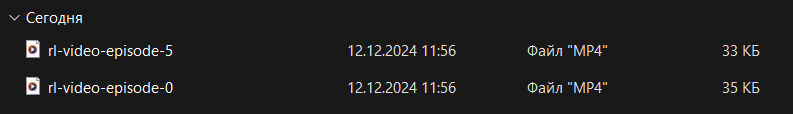